In [1]:
import numpy as np
import cv2
from PIL import Image,ImageEnhance
import copy
import matplotlib.pyplot as plt
from skimage import color
import random
import os
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
# Helper functions
# definition to readfile
def readfile(path):
    file = open(path, 'r')
    return file

# defintion to fetch bounding boxes
def fetch_bboxes(path):
    file = readfile(path)
    lines = file.readlines()
    # print(lines)
    bboxes = np.empty([len(lines),5], dtype=float)
    
    for i,line in enumerate(lines):
        # print(line)
        line = line.split()[0] + ' ' + ' '.join(line.split()[4:8])
        line = line.split()
        bboxes[i,:4] = line[1:]
    return bboxes

# defintion to fetch a random number
def gen_rand_num(begin,end):
    num = random.uniform(begin,end)
    return num

# definition to write augmented values to label file
def save_newbbox(newlabel_path,orig_path,bboxes):
    file_r = readfile(orig_path)
    lines = file_r.readlines()
    labels = []
    
    for i,line in enumerate(lines):
        #line[4:8] = '200 300 400 500'
        line = line.split()
        line[4:8] = [str(bbox) for bbox in bboxes[i,:4]]
        line = ' '.join(line)
        line = line + '\n'
        labels.append(line)
    file_w = open(newlabel_path + '.txt', 'w')
    file_w.writelines(labels)
    
# defintion to save augmented image    
def save_newimg(path, img_arr):    
    #image = Image.fromarray(conv2uint8(img_arr))
    #image.save(path + '.jpg')
    cv2.imwrite(path + '.jpg', conv2uint8(cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)))
    
# method to call save_augbbox and save_augimg
def save_newimgdata(image_info):
    save_newimg(image_info['newimg_path'] ,image_info['image_arr'])
    save_newbbox(image_info['newlabel_path'],image_info['origlabel_path'],
                 image_info['img_bboxes'])
    
def conv2uint8(image_arr):
    """image_arr = cv2.cvtColor(image_arr.
                             astype("float32"), cv2.COLOR_BGR2RGB)"""
    return (image_arr * 255).astype(np.uint8)

# Resize images to (960,544)
def resize_img_bbox(img_lb_tupl,dim):
    imgf, labelf = img_lb_tupl
    width, height = dim
    # resize and normalize image
    img_arr = cv2.imread(imgf, cv2.IMREAD_UNCHANGED)
    h0 = img_arr.shape[0]
    w0 = img_arr.shape[1]
    # img = img.resize((width,height))
    img_arr =  cv2.resize(img_arr,(width,height))
    # img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    print("Updated dimensions: ", img_arr.shape)
    # Scale factor in x and y axis
    # of resized image
    scale_x = height/h0
    scale_y = width/w0
    # resize bbox
    bboxes = fetch_bboxes(labelf)
    bboxes[:,[0,2]] = bboxes[:,[0,2]] * scale_x
    bboxes[:,[1,3]] = bboxes[:,[1,3]] * scale_y
    return img_arr,bboxes

def imlabel(impath, labels_path):
    #impath = 'data/kitti/custom_annotated/annotated_images/'
    #labels_path = 'data/kitti/custom_annotated/labels/'
    images = sorted(os.listdir(impath))
    labels = sorted(os.listdir(labels_path))
    imlabel_list = []
    for entity in zip(images, labels):
        entity = list(entity)
        entity[0] = impath + entity[0]
        entity[1] = labels_path + entity[1]
        imlabel_list.append(tuple(entity))
    return imlabel_list

In [3]:
imlabel_list = imlabel('data/kitti/custom_annotated/annotated_images/', 'data/kitti/custom_annotated/labels/')
imlabel_list

[('data/kitti/custom_annotated/annotated_images/2-wheeler-1.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-1.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-10.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-10.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-2.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-2.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-3.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-3.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-4.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-4.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-5.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-5.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-6.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-6.txt'),
 ('data/kitti/custom_annotated/annotated_images/2-wheeler-7.jpg',
  'data/kitti/custom_annotated/labels/2-wheeler-7.txt'),
 ('data/kitti/

Original dimensions:  (450, 900, 3)


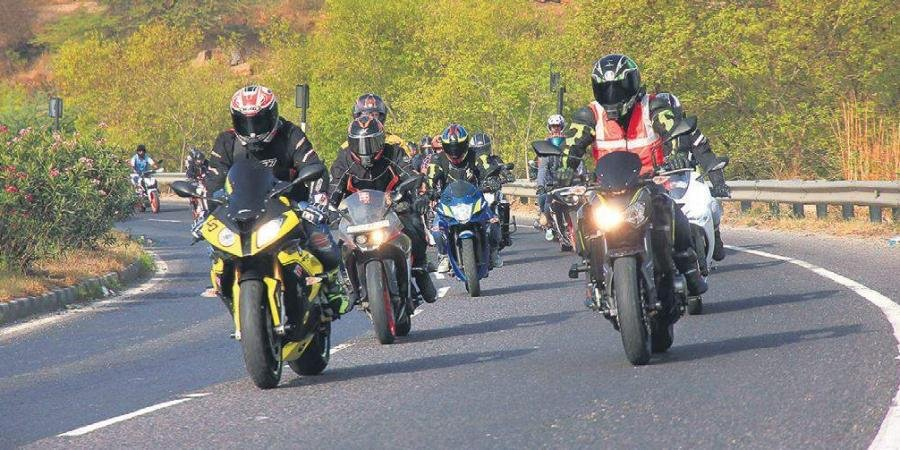

In [4]:
test_img = Image.open(imlabel_list[0][0])
test_img_arr = np.array(test_img)
print("Original dimensions: ",test_img_arr.shape)
test_img

Updated dimensions:  (544, 960, 3)


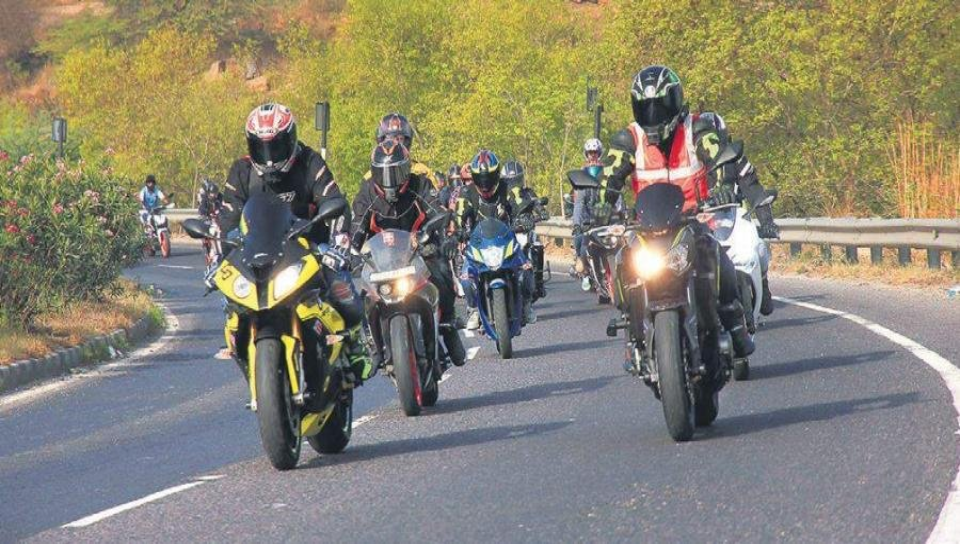

In [5]:
img_arr, bboxes = resize_img_bbox((imlabel_list[0][0],imlabel_list[0][1]), (960,544))
im_rgb_test = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
Image.fromarray(im_rgb_test)

In [6]:
testing_info = {
    'newimg_path': 'data/kitti/custom_annotated/testing/images/2-wheeler-1_resized',
    'image_arr': img_arr,
    'newlabel_path': 'data/kitti/custom_annotated/testing/labels/2-wheeler-1_resized',
    'origlabel_path': imlabel_list[0][1],
    'img_bboxes': bboxes
}

save_newimgdata(testing_info)

In [7]:
os.path.basename(imlabel_list[0][0])[:-4]

'2-wheeler-1'

In [8]:
newimgdir = 'data/kitti/custom_annotated/testing/images/'
newlbdir = 'data/kitti/custom_annotated/testing/labels/'
dim = (960,544)
resizeimg_info = {}

for item in imlabel_list:
    resize_imgname = os.path.basename(item[0])[:-4] + '_resized'
    resize_lbboxnm = os.path.basename(item[1])[:-4] + '_resized'
    resizeimg_info['image_arr'], resizeimg_info['img_bboxes'] = resize_img_bbox((item[0],item[1]),dim)
    resizeimg_info['newimg_path'] = newimgdir + resize_imgname
    resizeimg_info['newlabel_path'] = newlbdir + resize_lbboxnm
    resizeimg_info['origlabel_path'] = item[1]
    
    save_newimgdata(resizeimg_info)

Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)
Updated dimensions:  (544, 960, 3)


In [9]:
# For Spatial Augmentation
class Spatial_Aug:
    def __init__(self, image_path, label_path):
        self.image_arr = cv2.imread(image_path)/255
        # Convert to rgb float32, as opencv only works with float32
        self.image_arr = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
        self.bboxes = fetch_bboxes(label_path)
        
    def hflip (self):
        # Fetching image width
        image_width = np.array(self.image_arr.shape[:2])[::-1][0]
        # Horizontally stacking image width for further perusal
        image_width = np.hstack((image_width, image_width))
        # Reversing the image co-ordinates in the 1st dimension
        # i.e Hz_flipping the image
        self.image_arr = self.image_arr[:,::-1,:]
        # Calculating the new distance from origin
        self.bboxes[:,[0,2]] = image_width - self.bboxes[:,[0,2]]
        # Interchanging  x1,x2 co-ordinates
        # Method 1: Calculating the bbox width
        box_width = abs(self.bboxes[:,0] - self.bboxes[:,2])
        self.bboxes[:,0] -= box_width
        self.bboxes[:,2] += box_width
        # Method 2: Swap co-ordinates
        #bbox_x1 = bboxes[:,0]
        #bboxes[:,0] = bboxes[:,2]
        #bboxes[:,1] = bbox_x1
        
        #return self.image_arr,self.bboxes
        return self
    
    def translate (self, TxTy = (8,8)):
        rows,cols = self.image_arr.shape[:2]
        # Making a transition matrix
        # Here the shift is Tx=Ty=8
        Tx,Ty = TxTy
        rand_x = gen_rand_num(0,Tx)
        rand_y = gen_rand_num(0,Ty)
        M = np.float32([[1,0,rand_x],[0,1,rand_y]])
        self.image_arr = cv2.warpAffine(self.image_arr,M,(cols,rows))
        self.bboxes[:,[0,2]] += rand_x
        self.bboxes[:,[1,3]] += rand_y
        return self

In [10]:
# For Color Augmentation
class Color_Aug:
    def __init__(self, image_path, label_path):
        self.image_arr = cv2.imread(image_path)/255
        self.image_arr = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
        self.bboxes = fetch_bboxes(label_path)
    
    # definition to rotate hue of image
    def hue_rotate(self, hue_rot_max=0.5):    
        hsv = color.rgb2hsv(color.gray2rgb(self.image_arr))
        rand_hue_rot = gen_rand_num(0.1,hue_rot_max)
        #print("rand_hue_rot = ",rand_hue_rot)
        hsv[:, :, 0] = rand_hue_rot # adjust hue
        hsv[:, :, 1] = 1  # Turn up the saturation
        #return color.hsv2rgb(hsv)
        self.image_arr = color.hsv2rgb(hsv)
        return self
    
    """# defintion to adjust saturation
    def saturation(self, factor):
        rand_fact = gen_rand_num(0,factor)
        converter = ImageEnhance.Color(self.image)
        return converter.enhance(rand_fact)"""
    
    def saturation (self, factor=1.5):
        #imghsv = color.rgb2hsv(self.image_arr)
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        (h, s, v) = cv2.split(imghsv)
        factor = gen_rand_num(0.1,factor)
        # print("Random Factor = ",factor)
        s = s*factor
        s = np.clip(s,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        self.image_arr = imgrgb
        return self
    
    """def contrast_scale(self, factor):
        factor = gen_rand_num(0.2,factor)
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        imghsv = cv2.convertScaleAbs(self.image_arr, alpha=factor, beta=0)
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        return imgrgb"""
    def brightness (self, factor=1.5):
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        (h, s, v) = cv2.split(imghsv)
        factor = gen_rand_num(0.8,factor)
        # print("Random Factor = ",factor)
        v = v*factor
        v = np.clip(v,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        self.image_arr = imgrgb
        return self       

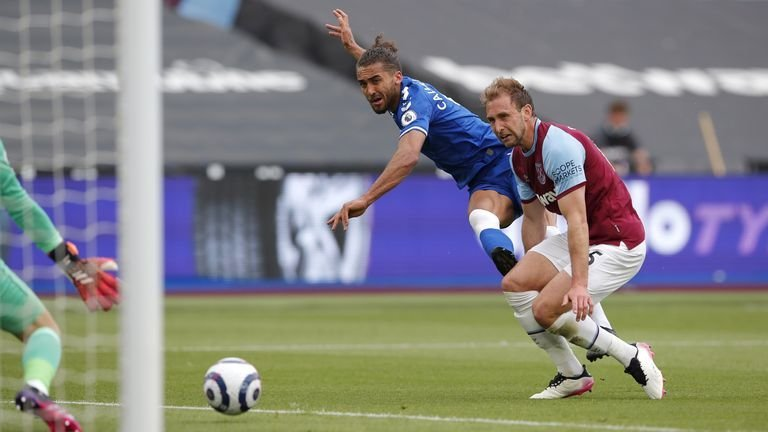

In [11]:
# Test code to fetch bounding boxes and image
from PIL import Image
image = Image.open('sports.jpg')
image

In [12]:
im_cv2 = cv2.imread('sports.jpg')
# im_cv2 = cv2.imread('sports.jpg')
# cv2.imwrite('cv2_test.jpg', im_cv2)

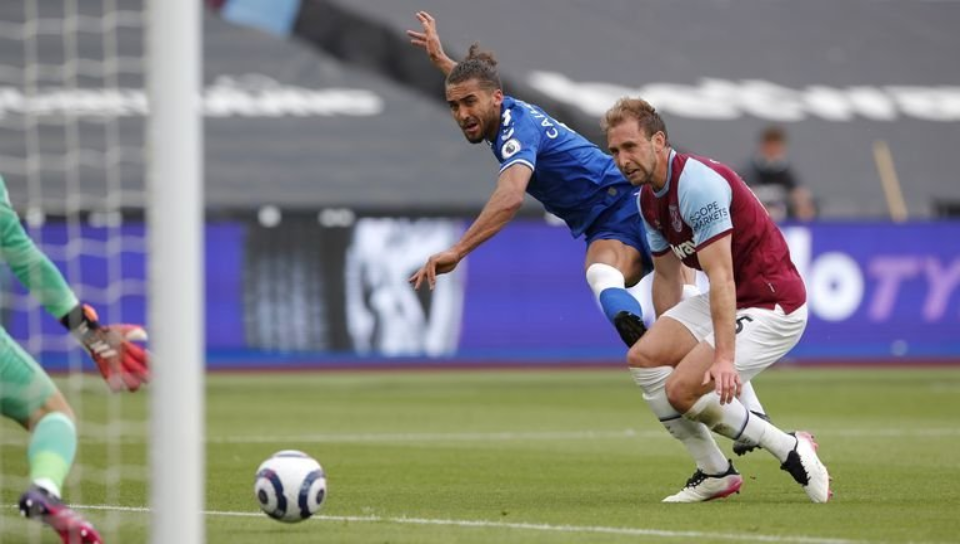

In [13]:
im_cv2 = cv2.resize(im_cv2, (960,544))
# im_cv2 = cv2.cvtColor(im_cv2, cv2.COLOR_BGR2RGB)
im_rgb = cv2.cvtColor(im_cv2, cv2.COLOR_BGR2RGB)
Image.fromarray(im_rgb)

In [14]:
cv2.imwrite('sports_cv2.jpg', im_cv2)

True

In [15]:
# Draw bbox on image
# Ref from Paperspace blog
def draw_bbox(img, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    img : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """    
    img = img.copy()
    
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2])/200))
    return img

In [16]:
bboxes = fetch_bboxes('/workspace/experiment/' + 'sports.txt')
bboxes

array([[315.,   6., 514., 403.,   0.],
       [479.,  76., 667., 412.,   0.],
       [196., 348., 269., 423.,   0.]])

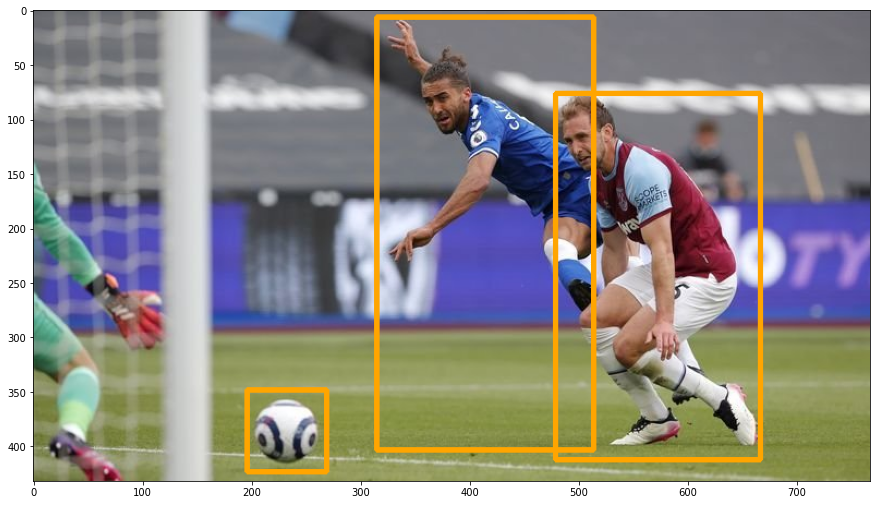

In [17]:
bbox_img = Image.fromarray(draw_bbox(np.asarray(image),
                                     bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_img)

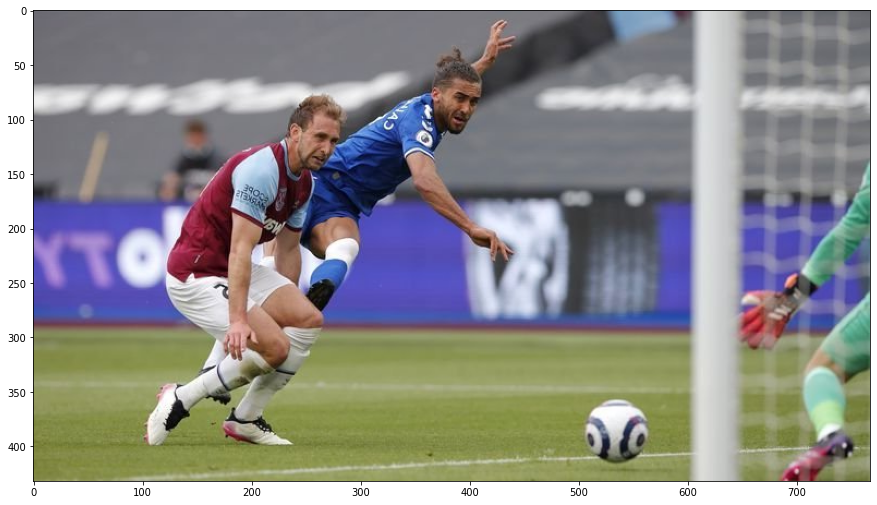

In [18]:
plt.imshow(Image.fromarray(np.asarray(image)[:,::-1,:]))

In [19]:
spat_aug = Spatial_Aug(image_path='/workspace/experiment/' + 'sports.jpg', 
                       label_path='/workspace/experiment/' + 'sports.txt')
print("Image shape: ", spat_aug.image_arr.shape)
print("Image bboxes:\n-------------------------------------------------\n",spat_aug.bboxes)
spat_aug = spat_aug.hflip()

Image shape:  (432, 768, 3)
Image bboxes:
-------------------------------------------------
 [[315.   6. 514. 403.   0.]
 [479.  76. 667. 412.   0.]
 [196. 348. 269. 423.   0.]]


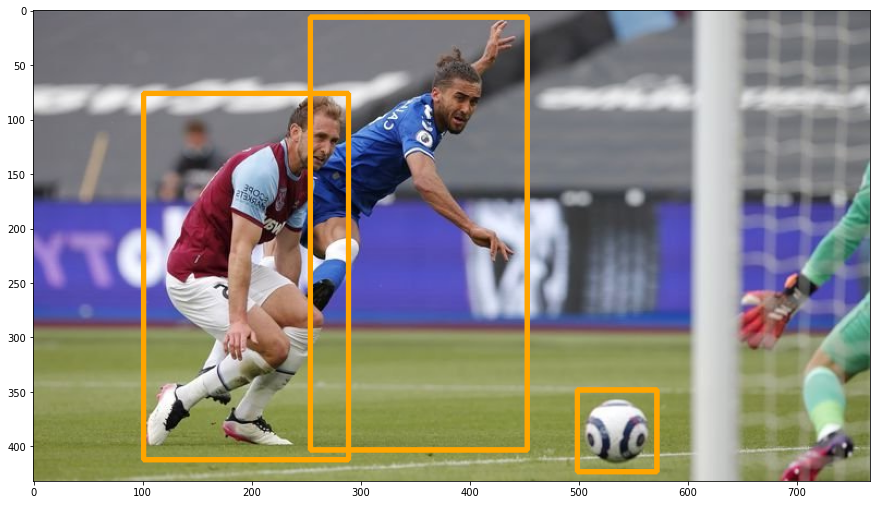

In [20]:
# spat_aug_rgb = cv2.cvtColor(spat_aug.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
bbox_flipim = Image.fromarray(draw_bbox(conv2uint8(spat_aug.image_arr),
                                     spat_aug.bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_flipim)

In [21]:
cv2.imwrite('sports_cv2_aug.jpg', conv2uint8(spat_aug.image_arr))

True

In [22]:
print("Bounding boxes before translation:\n", spat_aug.bboxes)
spat_aug_shift = Spatial_Aug(image_path='/workspace/experiment/' + 'sports.jpg', 
                       label_path='/workspace/experiment/' + 'sports.txt')
spat_aug_shift = spat_aug_shift.translate((8,8))
print("\n10th index of augmented image array:\n", spat_aug_shift.image_arr[10])
print("\nBounding boxes after translation:\n", spat_aug_shift.bboxes)

Bounding boxes before translation:
 [[254.   6. 453. 403.   0.]
 [101.  76. 289. 412.   0.]
 [499. 348. 572. 423.   0.]]

10th index of augmented image array:
 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.41727942 0.41335785 0.4447304 ]
 [0.41727942 0.41335785 0.4447304 ]
 [0.41727942 0.41335785 0.4447304 ]]

Bounding boxes after translation:
 [[319.31230909  10.40252253 518.31230909 407.40252253   0.        ]
 [483.31230909  80.40252253 671.31230909 416.40252253   0.        ]
 [200.31230909 352.40252253 273.31230909 427.40252253   0.        ]]


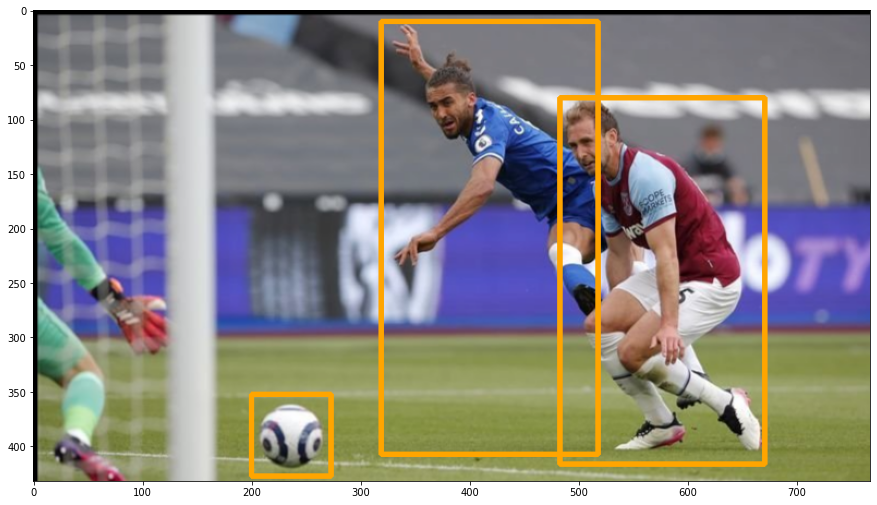

In [23]:
shfbbox_img = Image.fromarray(draw_bbox(conv2uint8(spat_aug_shift.image_arr),
                                     spat_aug_shift.bboxes[:,:4], color=[255,165,0]))
plt.imshow(shfbbox_img)

In [24]:
image_path = '/workspace/experiment/' + 'sports.jpg'
label_path = '/workspace/experiment/' + 'sports.txt'
col_aug = Color_Aug(image_path=image_path, label_path=label_path)
col_aug.image_arr[0]

array([[0.39607844, 0.4       , 0.41960785],
       [0.39607844, 0.4       , 0.41960785],
       [0.39607844, 0.4       , 0.41960785],
       ...,
       [0.45490196, 0.4509804 , 0.48235294],
       [0.45490196, 0.4509804 , 0.48235294],
       [0.45490196, 0.4509804 , 0.48235294]], dtype=float32)

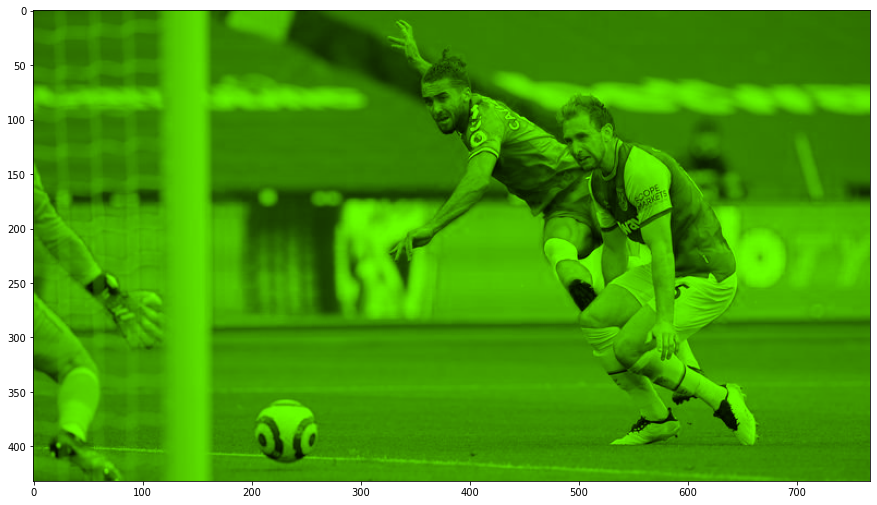

In [25]:
hue_img = col_aug.hue_rotate(0.5)
plt.imshow(Image.fromarray(conv2uint8(hue_img.image_arr)))

In [26]:
np.array(hue_img.image_arr)[0]

array([[0.17315763, 0.41960785, 0.        ],
       [0.17315763, 0.41960785, 0.        ],
       [0.17315763, 0.41960785, 0.        ],
       ...,
       [0.19905035, 0.48235294, 0.        ],
       [0.19905035, 0.48235294, 0.        ],
       [0.19905035, 0.48235294, 0.        ]], dtype=float32)

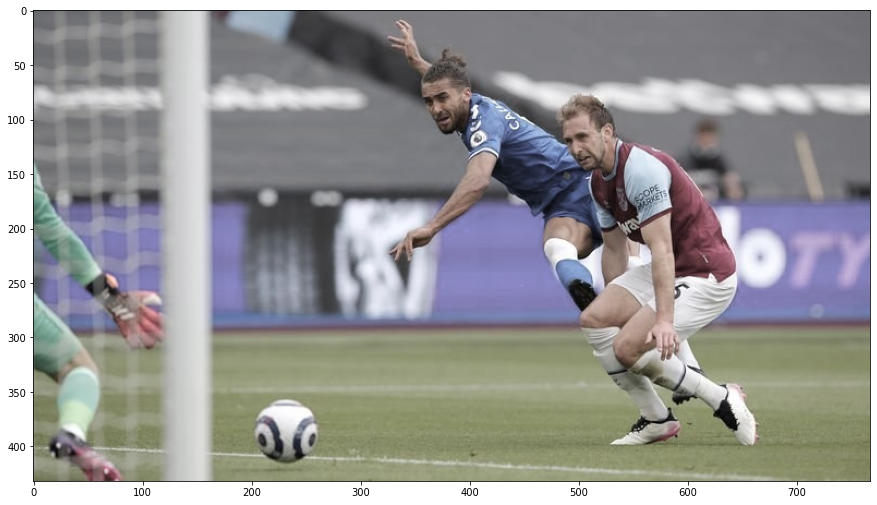

In [27]:
image_path = '/workspace/experiment/' + 'sports.jpg'
label_path = '/workspace/experiment/' + 'sports.txt'
col_aug = Color_Aug(image_path=image_path, label_path=label_path)
sat_img = col_aug.saturation(1.5)
plt.imshow(Image.fromarray(conv2uint8(sat_img.image_arr)))

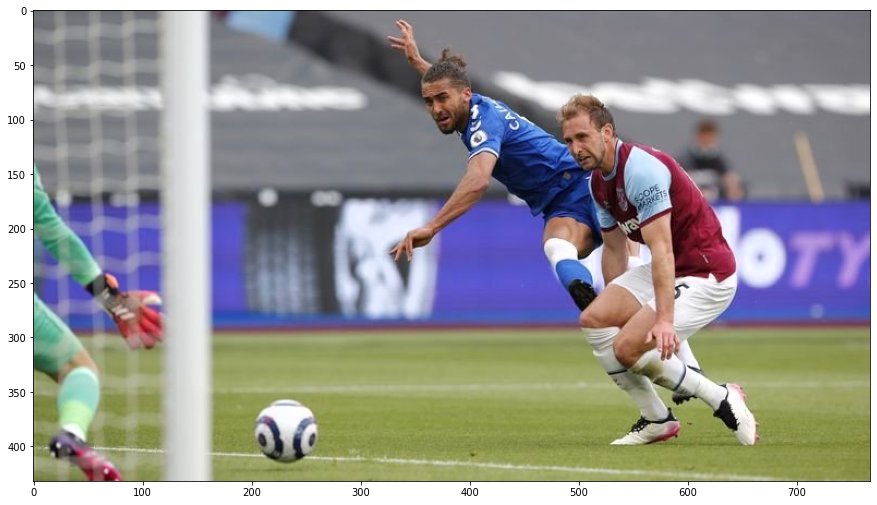

In [28]:
image_path = '/workspace/experiment/' + 'sports.jpg'
label_path = '/workspace/experiment/' + 'sports.txt'
col_aug = Color_Aug(image_path=image_path, label_path=label_path)
con_scale_img = col_aug.brightness(1.2)
plt.imshow(Image.fromarray(conv2uint8(con_scale_img.image_arr)))

In [29]:
impath = 'data/kitti/custom_annotated/annotated_images/'
labels_path = 'data/kitti/custom_annotated/labels/'
imlabel_list = imlabel(impath=impath,
                      labels_path=labels_path)
imlabel_list[5]

('data/kitti/custom_annotated/annotated_images/2-wheeler-5.jpg',
 'data/kitti/custom_annotated/labels/2-wheeler-5.txt')

In [30]:
# Randomizing augmentation class and type choice
spat_aug_dict = {
    'class' : Spatial_Aug,
    0 : 'hflip',
    1 : 'translate'
}

color_aug_dict = {
    'class' : Color_Aug,
    0 : 'hue_rotate',
    1 : 'saturation',
    2:  'brightness'
}

aug_classes = [spat_aug_dict, color_aug_dict]

In [31]:
image_info = {}
for i in range(0,2):
    for item in imlabel_list:
        print("Image File", item[0])
        # get the aug class
        aug_class = int(gen_rand_num(0,2))
        # get aug type
        num_types = len(aug_classes[aug_class]) - 1
        aug_type = int(gen_rand_num(0,num_types))
        # create aug class obj
        aug_class_obj = aug_classes[aug_class]['class'](item[0],item[1])
        # augment image_bbox object
        # aug_class_obj = aug_class_obj.aug_classes[aug_class][aug_type]
        # use get_attr to dynamically fetch the class method
        aug_class_method = getattr(aug_class_obj,aug_classes[aug_class][aug_type])
        # call the aug_type class method
        aug_class_obj = aug_class_method()
        # Fetching image, label names
        augimg_name = os.path.basename(item[0])[:-4] + '_'  + aug_classes[aug_class][aug_type]
        auglabel_name = os.path.basename(item[1])[:-4] + '_' + aug_classes[aug_class][aug_type]
        # Store image info in dictionary
        augimg_path = 'data/kitti/augmented_test/images/' + augimg_name
        auglabel_path = 'data/kitti/augmented_test/labels/' + auglabel_name
        origlabel_path = item[1]
        
        image_info['newimg_path'] = augimg_path
        image_info['newlabel_path'] = auglabel_path
        image_info['origlabel_path'] = origlabel_path
        image_info['img_bboxes'] = aug_class_obj.bboxes
        image_info['image_arr'] = aug_class_obj.image_arr
        
        save_newimgdata(image_info)

Image File data/kitti/custom_annotated/annotated_images/2-wheeler-1.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-10.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-2.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-3.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-4.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-5.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-6.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-7.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-8.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler-9.jpg
Image File data/kitti/custom_annotated/annotated_images/2-wheeler.jpg
Image File data/kitti/custom_annotated/annotated_images/pedestrian_0.jpg
Image File data/kitti/custom_annotated/annotated_images/pedestrian_1.jpg
Image File data/kitti/custom_annotated/annotated_images/pedestr

In [32]:
""""test_obj = Spatial_Aug('data/kitti/annotated_images/2-wheeler-1.jpg', 'data/kitti/labels/2-wheeler-1.txt')
test_method = getattr(test_obj, spat_aug_dict[0])
test_method
myobj = test_method()"""

'"test_obj = Spatial_Aug(\'data/kitti/annotated_images/2-wheeler-1.jpg\', \'data/kitti/labels/2-wheeler-1.txt\')\ntest_method = getattr(test_obj, spat_aug_dict[0])\ntest_method\nmyobj = test_method()'